In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
## Script to post-process the single-field integrals computed by the C++ code. This computes the shot-noise rescaling parameter, alpha, from a data derived covariance matrix.
## We output the data and theory jackknife covariance matrices, in addition to full theory covariance matrices and (quadratic-bias corrected) precision matrices. The effective number of samples, N_eff, is also computed.

import numpy as np
import sys,os
        
jackknife_file_11 = '../../xi_functions/xi_jack/xi_jack_n39_m24_j169_11.dat'
jackknife_file_22 = '../../xi_functions/xi_jack/xi_jack_n39_m24_j169_11.dat'
weight_dir = '../../mock1/'
file_root = '../../mock1/'
m = 24
n_samples = 10
outdir = '../../mock1/multi_alpha/'

# Create output directory
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [15]:
## First load jackknife xi estimates from data:
print("Loading correlation function jackknife estimates")
xi_jack_11 = np.loadtxt(jackknife_file_11,skiprows=2)
xi_jack_22 = np.loadtxt(jackknife_file_22,skiprows=2)
assert xi_jack_11.shape==xi_jack_22.shape,'Must have the same number of jackknifes for each field.'

n_bins = xi_jack_11.shape[1] # total bins
n_jack = xi_jack_11.shape[0] # total jackknives
n = n_bins//m # radial bins
xi_jack_all = [xi_jack_11,xi_jack_22]


# First exclude any dodgy jackknife regions
good_jk=np.unique(np.where(np.isfinite(xi_jack_11)&np.isfinite(xi_jack_22))[0])
print("Using %d out of %d jackknives"%(len(good_jk),n_jack))

indices = ['11','22']

def load_matrices(index,field,jack=True):
    """Load intermediate or full autocovariance matrices. 
    The field parameter controls which field covariance matrix to load"""
    if jack:
        cov_root = file_root+'CovMatricesJack/'
    else:
        cov_root = file_root+'CovMatricesAll/'
    suffix2 = '_n%d_m%d_%s%s_%s.txt'%(n,m,field,field,index)
    suffix3 = '_n%d_m%d_%s,%s%s_%s.txt'%(n,m,field,field,field,index)
    suffix4 = '_n%d_m%d_%s%s,%s%s_%s.txt'%(n,m,field,field,field,field,index)
    c2 = np.diag(np.loadtxt(cov_root+'c2'+suffix2))
    c3 = np.loadtxt(cov_root+'c3'+suffix3)
    c4 = np.loadtxt(cov_root+'c4'+suffix4)
    if jack:
        EEaA1 = np.loadtxt(cov_root+'EE1'+suffix2)
        EEaA2 = np.loadtxt(cov_root+'EE2'+suffix2)
        RRaA1 = np.loadtxt(cov_root+'RR1'+suffix2)
        RRaA2 = np.loadtxt(cov_root+'RR2'+suffix2)
    
        # Compute disconnected term
        w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
        w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
        diff1 = EEaA1-w_aA1*EEaA1.sum(axis=0)
        diff2 = EEaA2-w_aA2*EEaA2.sum(axis=0)
        RRaRRb = np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
        fact = np.ones_like(c4)-np.matmul(np.asmatrix(weights).T,np.asmatrix(weights))
        cx = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))
        c4+=cx
    
    # Now symmetrize and return matrices
    return c2,0.5*(c3+c3.T),0.5*(c4+c4.T)

alpha_best = np.zeros(2)

## Optimize for alpha_1 and alpha_2 separately.
for i,index in enumerate(indices):

    # Load in weights and pair counts
    weight_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_%s.dat'%(n,m,n_jack,index)
    RR_file = weight_dir+'binned_pair_counts_n%d_m%d_j%d_%s.dat'%(n,m,n_jack,index)
    print("Loading weights file from %s"%weight_file)
    weights = np.loadtxt(weight_file)[:,1:]
    print("Loading weights file from %s"%RR_file)
    RR=np.loadtxt(RR_file)

    # Filter out bad jackknifes
    xi_jack = xi_jack_all[i][good_jk]
    weights = weights[good_jk]

    # Compute data covariance matrix
    print("Computing data covariance matrix for field %d"%(i+1))
    mean_xi = np.sum(xi_jack*weights,axis=0)/np.sum(weights,axis=0)
    tmp = weights*(xi_jack-mean_xi)
    data_cov = np.matmul(tmp.T,tmp)
    denom = np.matmul(weights.T,weights)
    data_cov /= (np.ones_like(denom)-denom)

    # Load in full jackknife theoretical matrices
    print("Loading best estimate of jackknife covariance matrix for field %d"%(i+1))
    c2,c3,c4=load_matrices('full',i+1)
    
    # Load in partial jackknife theoretical matrices
    c2s,c3s,c4s=[],[],[]
    for j in range(n_samples):
        print("Loading field %d jackknife subsample %d of %d"%(i+1,j+1,n_samples))
        c2,c3,c4=load_matrices(j,i+1)
        c2s.append(c2)
        c3s.append(c3)
        c4s.append(c4)

    # Compute inverted matrix
    def Psi(alpha):
        """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
        c_tot = c2*alpha**2.+c3*alpha+c4
        partial_cov=[]
        for i in range(n_samples):
            partial_cov.append(alpha**2.*c2s[i]+alpha*c3s[i]+c4s[i])
        tmp=0.
        for i in range(n_samples):
            c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
            tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
        D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
        Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(c_tot))
        return Psi

    def neg_log_L1(alpha):
        """Return negative log L1 likelihood between data and theory covariance matrices"""
        Psi_alpha = Psi(alpha)
        logdet = np.linalg.slogdet(Psi_alpha)
        if logdet[0]<0:
            # Remove any dodgy inversions
            return np.inf        
        return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]


    # Now optimize for shot-noise rescaling parameter alpha
    print("Optimizing for the shot-noise rescaling parameter alpha_%d"%(i+1))
    from scipy.optimize import fmin
    optimal_alpha = fmin(neg_log_L1,1.5)
    print("Optimization complete for field %d - optimal rescaling parameter is alpha_%d = %.6f"%(i+1,i+1,optimal_alpha))
    
    alpha_best[i]=optimal_alpha


Loading correlation function jackknife estimates
Using 168 out of 169 jackknives
Loading weights file from ../../mock1/jackknife_weights_n39_m24_j169_11.dat
Loading weights file from ../../mock1/binned_pair_counts_n39_m24_j169_11.dat
Computing data covariance matrix for field 1
Loading best estimate of jackknife covariance matrix for field 1
Loading field 1 jackknife subsample 1 of 10
Loading field 1 jackknife subsample 2 of 10
Loading field 1 jackknife subsample 3 of 10
Loading field 1 jackknife subsample 4 of 10
Loading field 1 jackknife subsample 5 of 10
Loading field 1 jackknife subsample 6 of 10
Loading field 1 jackknife subsample 7 of 10
Loading field 1 jackknife subsample 8 of 10
Loading field 1 jackknife subsample 9 of 10
Loading field 1 jackknife subsample 10 of 10
Optimizing for the shot-noise rescaling parameter alpha_1
Optimization terminated successfully.
         Current function value: -3506881405925576.000000
         Iterations: 68
         Function evaluations: 136
Op

IOError: ../../mock1/CovMatricesJack/c2_n39_m24_22_full.txt not found.

In [ ]:
# input indices
I1 = [1,1,1,1,2,2]
I2 = [1,2,2,1,1,2]
I3 = [1,1,2,2,2,2]
I4 = [1,1,1,2,2,2]

In [18]:
print("REMOVE THIS")
I1 = [1,1,1,1,1,1]
I2 = I1; I3 = I1; I4=I1;
alpha_best = [1.1,1.1]

REMOVE THIS


In [22]:
## Define arrays for covariance matrices
c2s,c2js=[np.zeros([2,2,n*m,n*m]) for _ in range(2)]
RRs=np.zeros([2,2,n*m])
diff1s,diff2s,JK_weights=[np.zeros([2,2,n_jack,n*m]) for _ in range(3)]
c3s,c3js=[np.zeros([2,2,2,n*m,n*m]) for _ in range(2)]
c4s,c4js=[np.zeros([2,2,2,2,n*m,n*m]) for _ in range(2)]  

def matrix_readin(suffix='full'):
    """Read in multi-field covariance matrices. This returns lists of full and jackknife covariance matrices"""

    for ii in range(len(I1)):
        index4="%d%d,%d%d"%(I1[ii],I2[ii],I3[ii],I4[ii])
        index3="%d,%d%d"%(I2[ii],I1[ii],I3[ii])
        index2="%d%d"%(I1[ii],I2[ii])
        j1,j2,j3,j4=I1[ii]-1,I2[ii]-1,I3[ii]-1,I4[ii]-1 # internal indexing

        # Define input files
        file_root_all=file_root+'CovMatricesAll/'
        file_root_jack=file_root+'CovMatricesJack/'
        rr_true_file =weight_dir+'binned_pair_counts_n%d_m%d_j%d_%s.dat'%(n,m,n_jack,index2)
        weights_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_%s.dat'%(n,m,n_jack,index2)
        
        if suffix=='full':
            counts_file = file_root_all+'total_counts_n%d_m%d_%s.txt'%(n,m,index4)
            # Load total number of counts
            total_counts=np.loadtxt(counts_file)
            print("Reading in integral components for C_{%s}, which used %.2e pairs, %.2e triples and %.2e quads of particles"%(index4,total_counts[0],total_counts[1],total_counts[2]))
        else: 
            print("Reading in integral components for C_{%s}, iteration %s"%(index4,suffix))
            
        # Load jackknife weights
        weights=np.loadtxt(weights_file)[:,1:] 

        # Load pair counts
        rr_true = np.loadtxt(rr_true_file)

        # Load full integrals
        c2=np.diag(np.loadtxt(file_root_all+'c2_n%d_m%d_%s_%s.txt' %(n,m,index2,suffix)))
        c3=np.loadtxt(file_root_all+'c3_n%d_m%d_%s_%s.txt' %(n,m,index3,suffix))
        c4=np.loadtxt(file_root_all+'c4_n%d_m%d_%s_%s.txt' %(n,m,index4,suffix))

        # Load jackknife integrals
        c2j=np.diag(np.loadtxt(file_root_jack+'c2_n%d_m%d_%s_%s.txt' %(n,m,index2,suffix)))
        c3j=np.loadtxt(file_root_jack+'c3_n%d_m%d_%s_%s.txt' %(n,m,index3,suffix))
        c4j=np.loadtxt(file_root_jack+'c4_n%d_m%d_%s_%s.txt' %(n,m,index4,suffix))

        # Define cxj components
        EEaA1 = np.loadtxt(file_root_jack+'EE1_n%d_m%d_%s_%s.txt' %(n,m,index2,suffix))
        EEaA2 = np.loadtxt(file_root_jack+'EE2_n%d_m%d_%s_%s.txt' %(n,m,index2,suffix))
        RRaA1 = np.loadtxt(file_root_jack+'RR1_n%d_m%d_%s_%s.txt' %(n,m,index2,suffix))
        RRaA2 = np.loadtxt(file_root_jack+'RR2_n%d_m%d_%s_%s.txt' %(n,m,index2,suffix))
        w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
        w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
        EEa1 = np.sum(EEaA1,axis=0)
        EEa2 = np.sum(EEaA2,axis=0)
        diff1 = EEaA1-w_aA1*EEa1
        diff2 = EEaA2-w_aA2*EEa2

        # Now save components
        RRs[j1,j2]=rr_true
        JK_weights[j1,j2]=weights
        c2s[j1,j2]=c2
        c2js[j1,j2]=c2j
        diff1s[j1,j2]=diff1
        diff2s[j1,j2]=diff2
        c3s[j2,j1,j3]=c3
        c3js[j2,j1,j3]=c3j
        c4s[j1,j2,j3,j4]=c4
        c4js[j1,j2,j3,j4]=c4j

    def construct_fields(j1,j2,j3,j4,alpha1,alpha2):
        # Reconstruct the full field for given input fields and rescaling parameters

        # Create kronecker deltas
        d_xw=(j1==j4)
        d_xz=(j1==j3)
        d_yw=(j2==j4)
        d_yz=(j2==j3)

        # Compute disconnected piece
        t1=np.matmul(diff1s[j1,j2].T,diff2s[j3,j4])
        t2=np.asarray(np.matmul(np.asmatrix(RRs[j1,j2]).T,np.asmatrix(RRs[j3,j4])))
        t3=1.-np.matmul(JK_weights[j1,j2].T,JK_weights[j3,j4])
        cxj=t1/(t2*t3)

        full=c4s[j1,j2,j3,j4]+0.25*alpha1*(d_xw*c3s[j1,j2,j3]+d_xz*c3s[j1,j2,j4])+0.25*alpha2*(d_yw*c3s[j2,j1,j3]+d_yz*c3s[j2,j1,j4])+0.5*alpha1*alpha2*(d_xw*d_yz+d_xz*d_yw)*c2s[j1,j2]
        jack=c4js[j1,j2,j3,j4]+0.25*alpha1*(d_xw*c3js[j1,j2,j3]+d_xz*c3js[j1,j2,j4])+0.25*alpha2*(d_yw*c3js[j2,j1,j3]+d_yz*c3js[j2,j1,j4])+0.5*alpha1*alpha2*(d_xw*d_yz+d_xz*d_yw)*c2js[j1,j2]+cxj
        return full,jack

    c_tot = np.zeros([2,2,2,2,n*m,n*m])
    cj_tot = np.zeros([2,2,2,2,n*m,n*m])

    for j1 in range(2):
        for j2 in range(2):
            for j3 in range(2):
                for j4 in range(2):
                    c_tot[j1,j2,j3,j4],cj_tot[j1,j2,j3,j4]=construct_fields(j1,j2,j3,j4,alpha_best[0],alpha_best[1])

    return c_tot,cj_tot

In [24]:
c_subsamples,cj_subsamples=[],[]
for i in range(n_samples):
    tmp=matrix_readin(i)
    c_subsamples.append(tmp[0])
    cj_subsamples.append(tmp[1])

Reading in integral components for C_{11,11}, iteration 0
Reading in integral components for C_{11,11}, iteration 0
Reading in integral components for C_{11,11}, iteration 0
Reading in integral components for C_{11,11}, iteration 0
Reading in integral components for C_{11,11}, iteration 0
Reading in integral components for C_{11,11}, iteration 0


/home/oliver/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in divide
/home/oliver/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in divide


Reading in integral components for C_{11,11}, iteration 1
Reading in integral components for C_{11,11}, iteration 1
Reading in integral components for C_{11,11}, iteration 1
Reading in integral components for C_{11,11}, iteration 1
Reading in integral components for C_{11,11}, iteration 1
Reading in integral components for C_{11,11}, iteration 1
Reading in integral components for C_{11,11}, iteration 2
Reading in integral components for C_{11,11}, iteration 2
Reading in integral components for C_{11,11}, iteration 2
Reading in integral components for C_{11,11}, iteration 2
Reading in integral components for C_{11,11}, iteration 2
Reading in integral components for C_{11,11}, iteration 2
Reading in integral components for C_{11,11}, iteration 3
Reading in integral components for C_{11,11}, iteration 3
Reading in integral components for C_{11,11}, iteration 3
Reading in integral components for C_{11,11}, iteration 3
Reading in integral components for C_{11,11}, iteration 3
Reading in int

In [ ]:
    I1 = [1,1,1,1,2,2]
    I2 = [1,2,2,1,1,2]
    I3 = [1,1,2,2,2,2]
    I4 = [1,1,1,2,2,2]
    
## Define arrays for covariance matrices
c2s,c2js=[np.zeros([2,2,n*m,n*m]) for _ in range(2)]
RRs=np.zeros([2,2,n*m])
diff1s,diff2s,JK_weights=[np.zeros([2,2,J,n*m]) for _ in range(3)]
c3s,c3js=[np.zeros([2,2,2,n*m,n*m]) for _ in range(2)]
c4s,c4js=[np.zeros([2,2,2,2,n*m,n*m]) for _ in range(2)]
  
raise Exception("Remove symmetry factors for single-field case")
  
for ii in range(len(I1)):
    index4="%d%d,%d%d"%(I1[ii],I2[ii],I3[ii],I4[ii])
    index3="%d,%d%d"%(I2[ii],I1[ii],I3[ii])
    index2="%d%d"%(I1[ii],I2[ii])
    j1,j2,j3,j4=I1[ii]-1,I2[ii]-1,I3[ii]-1,I4[ii]-1 # internal indexing
    
    # Define input files
    file_root_all=root_dir+'CovMatricesAll/'
    file_root_jack=root_dir+'CovMatricesJack/'
    rr_true_file =root_dir+'weight_files/binned_pair_counts_n%d_m%d_j%d_%s.dat'%(n,m,J,index2)
    rr_file=file_root_all+'RR_n%d_m%d_%s_full.txt'%(n,m,index2)
    weights_file = root_dir+'weight_files/jackknife_weights_n%d_m%d_j%d_%s.dat'%(n,m,J,index2)
    counts_file = root_dir+'CovMatricesAll/total_counts_n%d_m%d_%s.txt'%(n,m,index4)

    # Load total number of counts
    total_counts=np.loadtxt(counts_file)
    print("Reading in integral components for C_{%s}, which used %.2e pairs, %.2e triples and %.2e quads of particles"%(index4,total_counts[0],total_counts[1],total_counts[2]))
    
    # Load jackknife weights
    weights=np.loadtxt(weights_file)[:,1:] 

    # Load pair counts
    #TODO: Remove rr_est?
    rr_est = np.loadtxt(rr_file)
    rr_true = np.loadtxt(rr_true_file)

    # Load bin counts
    #TODO: Remove?
    binct2=np.loadtxt(file_root_all+'binct_c2_n%d_m%d_%s_full.txt'%(n,m,index2))
    binct3=np.loadtxt(file_root_all+'binct_c3_n%d_m%d_%s_full.txt'%(n,m,index3))
    binct4=np.loadtxt(file_root_all+'binct_c4_n%d_m%d_%s_full.txt'%(n,m,index4))
    binct3=(binct3+binct3.T)/2.
    binct4=(binct4+binct4.T)/2.

    # Load full integrals
    c2=np.diag(np.loadtxt(file_root_all+'c2_n%d_m%d_%s_full.txt' %(n,m,index2)))
    c3=np.loadtxt(file_root_all+'c3_n%d_m%d_%s_full.txt' %(n,m,index3))
    c4=np.loadtxt(file_root_all+'c4_n%d_m%d_%s_full.txt' %(n,m,index4))
    errc4=np.loadtxt(file_root_all+'c4err_n%d_m%d_%s_full.txt' %(n,m,index4))

    # Load jackknife integrals
    c2j=np.diag(np.loadtxt(file_root_jack+'c2_n%d_m%d_%s_full.txt' %(n,m,index2)))
    c3j=np.loadtxt(file_root_jack+'c3_n%d_m%d_%s_full.txt' %(n,m,index3))
    c4j=np.loadtxt(file_root_jack+'c4_n%d_m%d_%s_full.txt' %(n,m,index4))
    errc4j=np.loadtxt(file_root_jack+'c4err_n%d_m%d_%s_full.txt' %(n,m,index4))
    
    # Define cxj components
    EEaA1 = np.loadtxt(file_root_jack+'EE1_n%d_m%d_%s_full.txt' %(n,m,index2))
    EEaA2 = np.loadtxt(file_root_jack+'EE2_n%d_m%d_%s_full.txt' %(n,m,index2))
    RRaA1 = np.loadtxt(file_root_jack+'RR1_n%d_m%d_%s_full.txt' %(n,m,index2))
    RRaA2 = np.loadtxt(file_root_jack+'RR2_n%d_m%d_%s_full.txt' %(n,m,index2))
    w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
    w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
    EEa1 = np.sum(EEaA1,axis=0)
    EEa2 = np.sum(EEaA2,axis=0)
    diff1 = EEaA1-w_aA1*EEa1
    diff2 = EEaA2-w_aA2*EEa2

    # Now save components
    RRs[j1,j2]=rr_true
    JK_weights[j1,j2]=weights
    c2s[j1,j2]=c2
    c2js[j1,j2]=c2j
    diff1s[j1,j2]=diff1
    diff2s[j1,j2]=diff2
    c3s[j2,j1,j3]=c3
    c3js[j2,j1,j3]=c3j
    c4s[j1,j2,j3,j4]=c4
    c4js[j1,j2,j3,j4]=c4j
    
# Reconstruct single field integrals
if multi_field==0:
    c2=c2s[0,0]
    c2j=c2js[0,0]
    diff1=diff1s[0,0]
    diff2=diff2s[0,0]
    c3=c3s[0,0,0]
    c3j=c3js[0,0,0]
    c4=c4s[0,0,0,0]
    c4j=c4js[0,0,0,0]
    RR=RRs[0,0]
    JK_weight=JK_weights[0,0]
    RRaRRb=np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
    fact=np.eye(n*m)-np.matmul(np.asmatrix(JK_weight).T,np.asmatrix(JK_weight)) # 1 - SUM_A(w_aA*w_bA)
    cxj = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))
    
    # Define total field
    c_tot = c4+a*c3+a**2.*c2
    cj_tot = c4j+cxj+a*c3j+a**2.*c2j

    # Take transpose symmetry
    #TODO: Remove components?
    c3=(c3+c3.T)/2.
    c2=(c4+c4.T)/2.
    c3j=(c3j+c3j.T)/2.
    c4j=(c4j+c4j.T)/2.
    c_tot=(c_tot+c_tot.T)/2.
    cj_tot=(cj_tot+cj_tot.T)/2.
    
    np.savez(root_dir+"SingleFieldProcessedIntegrals.npz",c_tot=c_tot,cj_tot=cj_tot,shot_noise_rescaling=a)
    print("Output matrices written to %sSingleFieldProcessedIntegrals.npz" %root_dir)
    
    
else:
    print("\nReconstructing multi-field integrals")
    ## Reconstruct general case
    def construct_fields(j1,j2,j3,j4,a,a2):
        # Reconstruct the full field for given input fields and rescaling parameters
        
        # Create kronecker deltas
        d_xw=(j1==j4)
        d_xz=(j1==j3)
        d_yw=(j2==j4)
        d_yz=(j2==j3)
        
        # Compute disconnected piece
        t1=np.matmul(diff1s[j1,j2].T,diff2s[j3,j4])
        t2=np.asarray(np.matmul(np.asmatrix(RRs[j1,j2]).T,np.asmatrix(RRs[j3,j4])))
        t3=1.-np.matmul(JK_weights[j1,j2].T,JK_weights[j3,j4])
        cxj=t1/(t2*t3)
        
        full=c4s[j1,j2,j3,j4]+0.25*a*(d_xw*c3s[j1,j2,j3]+d_xz*c3s[j1,j2,j4])+0.25*a2*(d_yw*c3s[j2,j1,j3]+d_yz*c3s[j2,j1,j4])+0.5*a*a2*(d_xw*d_yz+d_xz*d_yw)*c2s[j1,j2]
        jack=c4js[j1,j2,j3,j4]+0.25*a*(d_xw*c3js[j1,j2,j3]+d_xz*c3js[j1,j2,j4])+0.25*a2*(d_yw*c3js[j2,j1,j3]+d_yz*c3js[j2,j1,j4])+0.5*a*a2*(d_xw*d_yz+d_xz*d_yw)*c2js[j1,j2]+cxj
        return full,jack
    
    c_tot = np.zeros([2,2,2,2,n*m,n*m])
    cj_tot = np.zeros([2,2,2,2,n*m,n*m])
    
    for j1 in range(2):
        for j2 in range(2):
            for j3 in range(2):
                for j4 in range(2):
                    c_tot[j1,j2,j3,j4],cj_tot[j1,j2,j3,j4]=construct_fields(j1,j2,j3,j4,a,a2)
    
        
    np.savez(root_dir+"MultiFieldProcessedIntegrals.npz",c_tot=c_tot,cj_tot=cj_tot,shot_noise_rescaling1=a,shot_noise_rescaling2=a2)
    print("\nOutput matrices writeen to %sMultiFieldProcessedIntegrals.npz"%root_dir)


## Now reconstruct fields

In [ ]:

# Compute jackknife and full covariance matrices
jack_cov = c4+c3*alpha_best+c2*alpha_best**2.
jack_prec = Psi(alpha_best)
c2f,c3f,c4f=load_matrices('full',jack=False)
full_cov = c4f+c3f*alpha_best+c2f*alpha_best**2.

# Compute full precision matrix
print("Computing the full precision matrix estimate:")
# Load in partial jackknife theoretical matrices
c2fs,c3fs,c4fs=[],[],[]
for i in range(n_samples):
    print("Loading full subsample %d of %d"%(i+1,n_samples))
    c2,c3,c4=load_matrices(i,jack=False)
    c2fs.append(c2)
    c3fs.append(c3)
    c4fs.append(c4)
partial_cov=[]
for i in range(n_samples):
    partial_cov.append(alpha_best**2.*c2fs[i]+alpha_best*c3fs[i]+c4fs[i])
tmp=0.
for i in range(n_samples):
    c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
    tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
full_D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
full_prec = np.matmul(np.eye(n_bins)-full_D_est,np.linalg.inv(full_cov))
print("Full precision matrix estimate computed")    

# Now compute effective N:
slogdetD=np.linalg.slogdet(full_D_est)
D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
N_eff_D = (n_bins+1.)/D_value+1.
print("Total N_eff Estimate: %.4e"%N_eff_D)        

output_name = outdir+'Rescaled_Covariance_Matrices_n%d_m%d_j%d.npz'%(n,m,n_jack)
np.savez(output_name,jackknife_theory_covariance=jack_cov,full_theory_covariance=full_cov,jackknife_data_covariance=data_cov,
         shot_noise_rescaling=alpha_best,jackknife_theory_precision=jack_prec,full_theory_precision=full_prec,N_eff=N_eff_D,
         full_theory_D_matrix=full_D_est,individual_theory_covariances=partial_cov)

print("Saved output covariance matrices as %s"%output_name)

In [67]:
def neg_log_L1(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

In [71]:
fmin(neg_log_L1,1.76)

Optimization terminated successfully.
         Current function value: -11254.047610
         Iterations: 12
         Function evaluations: 24


array([1.6919375])

In [72]:
from scipy.optimize import brentq

def fn_to_solve(alpha):
    c_tot = c4+alpha*c3+alpha**2.*c2
    tmp = c3+2.*alpha*c2
    tmp2=np.matmul(data_cov-c_tot,np.matmul(c_tot,np.matmul(tmp,c_tot)))
    return np.trace(tmp2)

def fn_to_solve2(alpha):
    prec=Psi(alpha)
    inv_prec = np.linalg.inv(prec)
    tmp = c3+2.*alpha*c2
    tmp2=np.matmul(data_cov-inv_prec,np.matmul(inv_prec,np.matmul(tmp,inv_prec)))
    return np.trace(tmp2)

In [73]:
brentq(fn_to_solve,0,3)

1.7100398051529564

In [74]:
brentq(fn_to_solve2,0,3)

0.06674536661444672

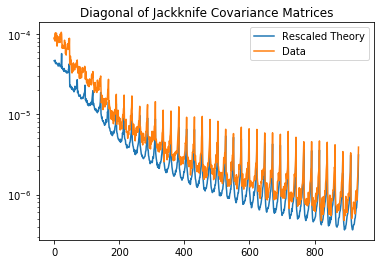

In [34]:
alpha_best=1.04
c_theory = alpha_best**2.*c2+alpha_best*c3+c4
plt.plot(np.diag(c_theory),label='Rescaled Theory')
plt.plot(np.diag(data_cov),label='Data')
plt.yscale('log');plt.title('Diagonal of Jackknife Covariance Matrices')
plt.legend();

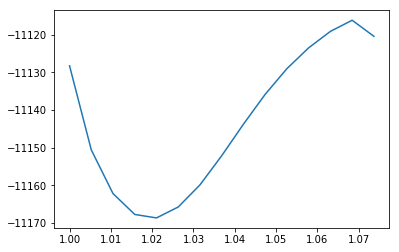

In [260]:
alphas = np.linspace(1.0,1.1,20)
funs = [neg_log_L1(a) for a in alphas]
plt.plot(alphas,funs)

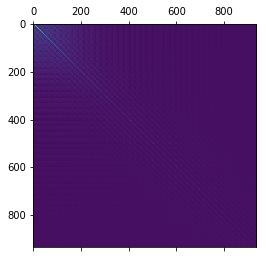

In [261]:
plt.matshow(c_theory)

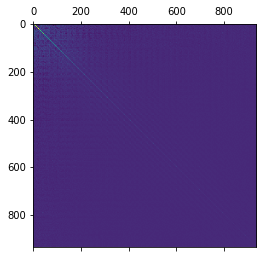

In [262]:
plt.matshow(data_cov)

## Test output

In [1]:
%pylab inline
data=np.load('../../mock1/Rescaled_Covariance_Matrices_n39_m24_j169.npz')

Populating the interactive namespace from numpy and matplotlib


In [3]:
%pylab inline
data=np.load('../../mock1/Rescaled_Covariance_Matrices_n39_m24_j169.npz')

def whiten(mat):
    diag = np.asmatrix(np.diag(mat))
    return mat/np.sqrt(np.matmul(diag.T,diag))

cov=data.f.full_theory_covariance
prec=data.f.full_theory_precision
data_cov = data.f.jackknife_data_covariance
D = data.f.full_theory_D_matrix
ind_cov = data.f.individual_theory_covariances

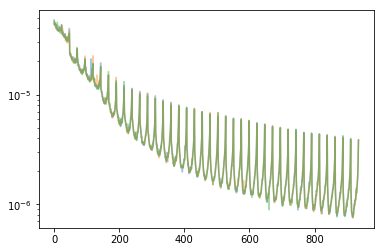

In [13]:
for i in range(3):
    plt.plot(np.diag(ind_cov[i]),alpha=0.4)
plt.yscale('log')

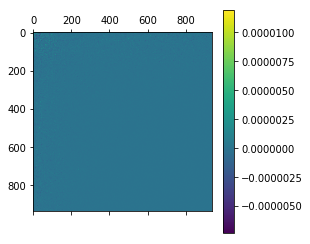

In [14]:
plt.matshow(ind_cov[10]-ind_cov[7]);plt.colorbar()

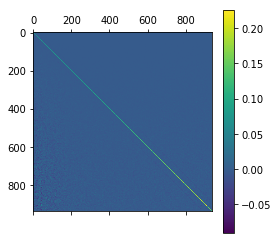

In [5]:
plt.matshow(D);plt.colorbar();

In [59]:
len(D)/np.exp(np.linalg.slogdet(D)[1]/len(D))

10774.426249388594

(360, 240)

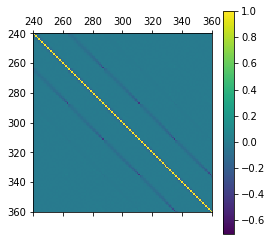

In [36]:
plt.matshow(whiten(prec));plt.colorbar()
plt.xlim([240,360]);plt.ylim([360,240])

In [32]:
data.f.N_eff

array(-588646.91918145)

## Check RR consistency

In [117]:
N_g = 642051
N_r = 6420510

In [118]:
RR_rascal = np.loadtxt('../../mock1/RR_n39_m24_11_full.txt')

In [119]:
RR_corrfunc=np.loadtxt('../../mock1/binned_pair_counts_n39_m24_j169_11.dat')*(float(N_g)/float(N_r))**2.

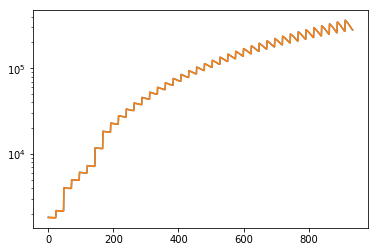

In [120]:
plt.plot(RR_corrfunc)
plt.plot(RR_rascal)
plt.yscale('log')

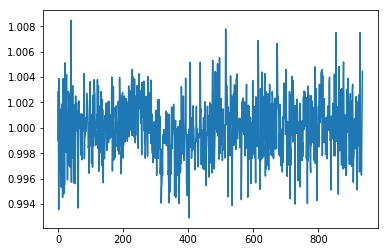

In [121]:
plt.plot(RR_rascal/RR_corrfunc)